# Python: Policy Learning with Trees

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate treatment policies.

## Data

The data will be generated with a simple data generating process to enable us to know the true policy cut-offs.

In [1]:
import numpy as np 
import pandas as pd
import doubleml as dml

Here, we consider a treatment effect that depends on two covariates which might correspond to opposite effects depending on age or income.
For simplicity, the treatment effect within each group is generated to be constant.

In [2]:
def group_effect(x):
    if x[0] <= -0.3:
        te = 1.2
    elif (x[0] >= 0.2) & (x[1] >= 0.4):
        te = 1
    else:
        te = -1
    return te

The data is generated as

$
\begin{align}
Y_i & = g(W_1,W_2)T_i + \langle W_i,\gamma_0\rangle + \epsilon_i \\
T_i & = \langle W_i,\beta_0\rangle +\eta_i,
\end{align}
$

where $W_i\sim\mathcal{N}(0,I_{d_w})$ and $\epsilon_i,\eta_i\sim\mathcal{U}[0,1]$.
The coefficient vectors $\gamma_0$ and $\beta_0$ both have small random support which values are drawn independently from $\mathcal{U}[0,1]$.
Further, $g(w_1,w_2)$ defines the conditional treatment effect, which is generated depending on $\{w_1,w_2\}$.

$$g(w_1) = \begin{cases}-1\quad &\text{for } w_1\le -0.3\\
1\quad &\text{for } w_1\ge  0.2 \land w_2\ge 0.4\\
0\quad &\text{otherwise. } \\
 \end{cases}$$

In [3]:
def create_synthetic_group_data(n_samples=200, n_w=10, support_size=5):
    """
    Creates a simple synthetic example for group effects.

    Parameters
    ----------
    n_samples : int
        Number of samples.
        Default is ``200``.

    n_w : int
        Dimension of covariates.
        Default is ``10``.

    support_size : int
        Number of relevant covariates.
        Default is ``5``.

    Returns
    -------
     data : pd.DataFrame
            A data frame.

    """
    # Outcome support
    support_w = np.random.choice(np.arange(n_w), size=support_size, replace=False)
    coefs_w = np.random.uniform(0, 1, size=support_size)
    # Define the function to generate the noise
    epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n_samples)
    # Treatment support
    # Assuming the matrices gamma and beta have the same number of non-zero components
    support_t = np.random.choice(np.arange(n_w), size=support_size, replace=False)
    coefs_t = np.random.uniform(0, 1, size=support_size)
    # Define the function to generate the noise
    eta_sample = lambda n: np.random.uniform(-1, 1, size=n_samples)

    # Generate controls, covariates, treatments and outcomes
    w = np.random.normal(0, 1, size=(n_samples, n_w))
    # Group treatment effect
    te = np.apply_along_axis(group_effect, axis=1, arr=w)
    # Define treatment
    log_odds = np.dot(w[:, support_t], coefs_t) + eta_sample(n_samples)
    t_sigmoid = 1 / (1 + np.exp(-log_odds))
    t = np.array([np.random.binomial(1, p) for p in t_sigmoid])
    # Define the outcome
    y = te * t + np.dot(w[:, support_w], coefs_w) + epsilon_sample(n_samples)

    # Now we build the dataset
    y_df = pd.DataFrame({'y': y})
    t_df = pd.DataFrame({'t': t})
    w_df = pd.DataFrame(data=w, index=np.arange(w.shape[0]), columns=[f'w_{i}' for i in range(w.shape[1])])

    data = pd.concat([y_df, t_df, w_df], axis=1)
    covariates = list(w_df.columns.values)

    return data, covariates

We will consider a quite small number of covariates to ensure fast calcualtion.

In [4]:
# DGP constants
np.random.seed(42)
n_samples = 500
n_w = 10
support_size = 5

# Create data
data, covariates = create_synthetic_group_data(n_samples=n_samples, n_w=n_w, support_size=support_size)
data_dml_base = dml.DoubleMLData(data,
                                 y_col='y',
                                 d_cols='t',
                                 x_cols=covariates)

## Interactive Regression Model (IRM)
The first step is to fit a [DoubleML IRM Model](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-model-irm) to the data.

In [5]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(42)

dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.01,
                          n_folds=5)
print("Training IRM Model")
dml_irm.fit(store_predictions=True)

Training IRM Model


## Policy Learning with Trees
Next, we specify the covariates as a [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) against which to learn the policy. This can either be all covariates $w_i$, or if domain knowledge is available we can use a subset.

In [6]:
x_vars = data[["w_0","w_1"]].copy()
x_vars.head()

,w_0,w_1
0,-0.428046,-0.742407
1,-0.600254,0.947440
2,-1.265119,1.091992
3,-1.346678,-0.880591
4,-1.508153,1.099647


To estimate a Policy just call the ``policy_tree()`` method and supply the DataFrame with the x_var definitions and the ``depth`` of the desired tree.

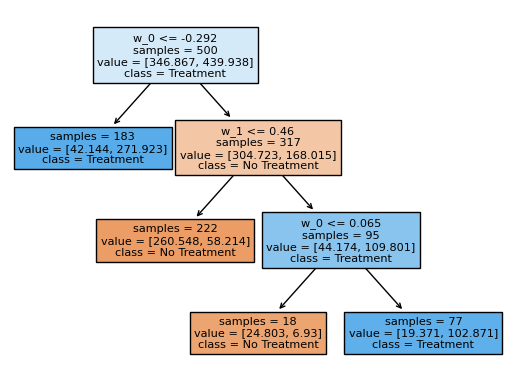

In [7]:
policy_tree = dml_irm.policy_tree(x_vars=x_vars, depth=3)
policy_tree.plot_tree();

Alternatively, it is also possible to estimate the tree on all covariates.

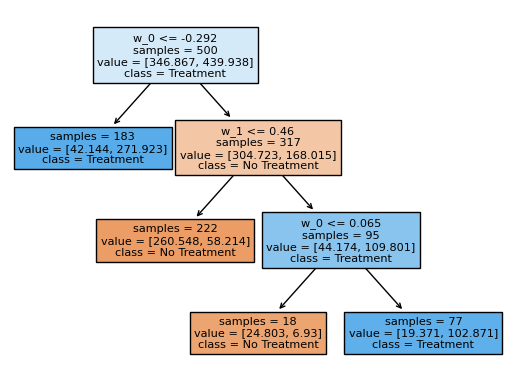

In [8]:
policy_tree_2 = dml_irm.policy_tree(x_vars=data[covariates], depth=3)
policy_tree_2.plot_tree();

With the `predict()` method you can create treatment predictions for new data.

In [10]:
new_data, _ = create_synthetic_group_data(n_samples=n_samples, n_w=n_w, support_size=support_size)
pred_df = policy_tree.predict(x_vars=new_data[["w_0","w_1"]])
pred_df.head()

,w_0,w_1,pred_treatment
0,0.783129,0.375986,0
1,0.464633,-0.070422,0
2,0.073059,-0.765550,0
3,0.437169,-0.321567,0
4,-0.612501,0.922746,1
